In [1]:
import torch
import torch.optim as optim 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
import numpy as np


In [2]:
import pandas as pd 
features = pd.read_csv('./features_notnormal.csv', header=None).values
target= pd.read_csv('./target_notnormal.csv', header=None).values

In [20]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert features to tensor
        self.y = torch.tensor(y, dtype=torch.float32)  # Convert labels to tensor
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return the data point and its label
        return self.X[idx], self.y[idx]

# dataset = CustomDataset(xyz_train, ener_train)
dataset = CustomDataset(features, target)

# Define the split ratio (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=True) 

In [12]:
# Define the AE model
import torch.nn.init as init

class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()

        self.regressor = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1) 
        )
        
        # self.apply(self.init_weights)

    # def init_weights(self, m):
    #     if isinstance(m, nn.Linear):  
    #         # init.constant_(m.weight, 1e-2)
    #         init.xavier_uniform_(m.weight)  # Xavier initialization
    #         # init.normal_(m.weight, mean=0.0, std=0.02)
    #         if m.bias is not None:
    #             init.zeros_(m.bias)  # Set biases to zero

    def forward(self, x):
        return self.regressor(x)
        

def dnn_loss(y_pred, y_true):
    return nn.MSELoss(reduction='mean')(y_pred, y_true)


In [13]:
epochs = 2000
learning_rate = 1e-3

history = []
model = DNN(input_dim=9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_samples = 0
    for batch_data in train_loader:
        x, y = batch_data 
        y_pred = model(x)
        loss = dnn_loss(y_pred, y.view(-1, 1))
        optimizer.zero_grad() 
        loss.backward() # Computes the gradient
        train_loss += loss.detach().item() * x.size(0)
        total_samples += x.size(0)  # Count samples in the batch
        optimizer.step() # update the parameters 
    avg_loss = train_loss / total_samples  # Normalize by number of batches

    model.eval()
    val_loss = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch_data in test_loader:
            x_val,y_val = batch_data
            yval_pred = model(x_val)
            loss = dnn_loss(yval_pred, y_val.view(-1, 1))
            val_loss += loss.detach().item() * x_val.size(0)
            total_val_samples += x_val.size(0)  # Count samples in the batch
    avg_val_loss = val_loss / total_val_samples  # Normalize by number of batches
    history.append([epoch,avg_loss, avg_val_loss])
    print(f"Epoch {epoch + 1}/{epochs}, train Loss: {avg_loss:.4f}")
    print(f"Epoch {epoch + 1}/{epochs}, test Loss: {avg_val_loss:.4f}")

history = np.array(history)

Epoch 1/2000, train Loss: 1.0982
Epoch 1/2000, test Loss: 1.2325
Epoch 2/2000, train Loss: 1.0146
Epoch 2/2000, test Loss: 1.1615
Epoch 3/2000, train Loss: 0.9669
Epoch 3/2000, test Loss: 1.1147
Epoch 4/2000, train Loss: 0.9379
Epoch 4/2000, test Loss: 1.0875
Epoch 5/2000, train Loss: 0.9213
Epoch 5/2000, test Loss: 1.0679
Epoch 6/2000, train Loss: 0.9096
Epoch 6/2000, test Loss: 1.0522
Epoch 7/2000, train Loss: 0.8977
Epoch 7/2000, test Loss: 1.0390
Epoch 8/2000, train Loss: 0.8868
Epoch 8/2000, test Loss: 1.0249
Epoch 9/2000, train Loss: 0.8749
Epoch 9/2000, test Loss: 1.0107
Epoch 10/2000, train Loss: 0.8635
Epoch 10/2000, test Loss: 0.9967
Epoch 11/2000, train Loss: 0.8507
Epoch 11/2000, test Loss: 0.9813
Epoch 12/2000, train Loss: 0.8383
Epoch 12/2000, test Loss: 0.9655
Epoch 13/2000, train Loss: 0.8251
Epoch 13/2000, test Loss: 0.9493
Epoch 14/2000, train Loss: 0.8118
Epoch 14/2000, test Loss: 0.9332
Epoch 15/2000, train Loss: 0.7982
Epoch 15/2000, test Loss: 0.9177
Epoch 16/2000

In [14]:
# import pandas as pd 
# train = pd.DataFrame(avg_loss)
# test = pd.DataFrame(avg_val_loss)

# train.to_csv("./bias_0_train.csv", header=False, index=False)
# test.to_csv("./bias_0_test.csv", header=False, index=False)

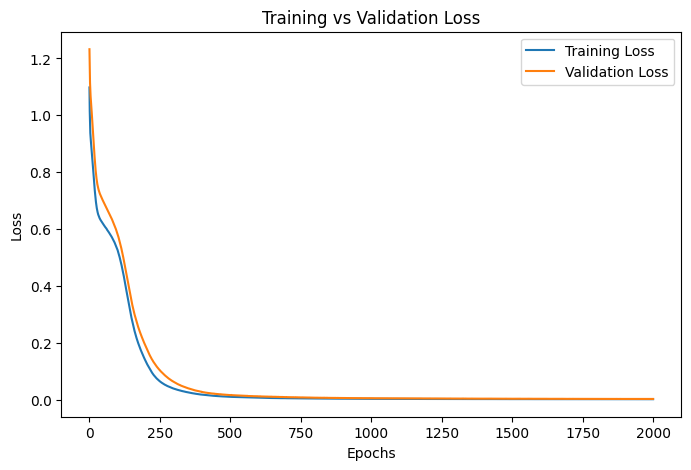

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(history[:,1], label="Training Loss")
plt.plot(history[:,2], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [25]:
train_loader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)

model.eval()
# Loop over the test set
with torch.no_grad():  # Disable gradient calculation for testing
    for batch_data in train_loader:
        x, y = batch_data
        y_pred = model(x)
        
model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        x_val,y_val = batch_data
        yval_pred = model(x_val)


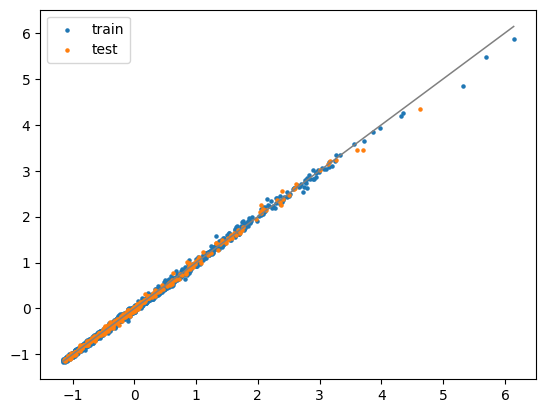

In [26]:
line_x = [min(y),max(y)] # yml is the original dataset, the total
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), label= 'train', alpha = 1, s=5)
plt.scatter(y_val.detach().numpy(), yval_pred.detach().numpy(), label= 'test', alpha = 1, s=5)
plt.plot(line_x,line_x, c='grey', lw = 1.1)#, zorder=0)
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import r2_score    
test_r2 = r2_score(y_val, yval_pred)
train_r2 = r2_score(y, y_pred)
print(train_r2, test_r2)

0.9979012277626291 0.9976956713245355
